Dieser Block erzeugt eine Darstellung, die die ganze Breite des Fensters ausnutzt.

In [1]:
%%HTML
<style>.container{width:100%;}</style>

Dieser Block schaltet die Überprüfung auf Schönheitsfehler ein. Wir ignorieren die Konvention, dass zwischen Definitionen zwei Leerzeilen stehen sollen, um die Lesbarkeit zu erhöhen. Wir erlauben auch mehrere Leerzeichen vor einem Operator, um sequenzielle Zuweisungen am `=` ausrichten zu können.

In [2]:
%load_ext pycodestyle_magic
%flake8_on --ignore E302,E305,E221

Wir benötigen außerdem *Graphviz* zur Visualisierung. Das Python-Paket wird ebenfalls mit den Befehlen oben installiert, zur korrekten Funktionsweise ist jedoch auch [Graphviz](http://graphviz.org "J. Ellson et al. (2020): Graphviz") selbst auf dem System zu installieren.

In [3]:
import graphviz

# Splay Trees

In diesem Notebook wird eine bestimmte Art von selbstbalancierenden Bäumen gezeigt, die *Splay Trees*. Diese Datenstruktur wurde [1985 von Sleator und Tarjan eingeführt](http://www.cs.cmu.edu/~sleator/papers/self-adjusting.pdf "D. D. Sleator, R. E. Tarjan (1985): Self-Adjusting Binary Search Trees. Journal of the ACM, 32(3) 652-686"). Im Gegensatz zu anderen selbstbalancierenden Bäumen wie *AVL-Bäumen* wird bei Splay Trees nicht gefordert, dass der Baum zu allen Zeiten so gut wie möglich balanciert ist. Stattdessen wird der Baum dahingehend optimiert, dass häufig verwendete Elemente nahe an der Wurzel sind.

Auf Basis dieser Bäume soll später eine alternative Implementierung von Mengen in der Programmiersprache Python entstehen. In der Referenzimplementierung *CPython* sind [Mengen auf Basis von *Hashtabellen* implementiert](https://github.com/python/cpython/blob/3.7/Objects/setobject.c "R. D. Hettinger et al. (2019): cpython/Objects/setobject.c, GitHub"). Viele andere weit verbreitete Implementierungen anderer Programmiersprachen benutzen für Mengen ebenfalls Hashtabellen oder haben dies zumindest als Option, wie in [Java](https://docs.oracle.com/en/java/javase/13/docs/api/java.base/java/util/Set.html "Oracle Corp. (2019): Set (Java SE13 & JDK 13)"), [.NET (C#)](https://docs.microsoft.com/en-us/dotnet/api/system.collections.generic.iset-1?view=netframework-4.8, "Microsoft Corp. (2019): ISet<T> Interface (System.Collections.Generic), Microsoft Docs"), [JavaScript](https://v8.dev/blog/hash-code "Sathya Gunasekaran (2018): Optimizing hash tables: hiding the hash code, V8 Blog") oder [PHP](https://www.php.net/manual/en/class.ds-set.php "The PHP Group (2019): PHP: Set, Manual"). Jedoch macht die Verwendung von Bäumen für Mengen einige mengenlastige Programmierprobleme einfacher zu lösen, da diese Mengen *geordnet* sind und somit beispielsweise ein einfach zu bestimmendes Minimum und ein Maximum haben.

Geordnete binäre Bäume eignen sich, um Mengen zu implementieren, da insbesondere in beiden keine doppelten Elemente vorkommen. Wir müssen für geordnete Mengen außerdem fordern, dass alle Elemente geordnet werden können. Wir behandeln später, wie wir beliebigen Nutzlasten in Python eine Ordnung geben können.

Die reine Datenstruktur – ohne Operationen – ist bei Splay Trees genauso wie bei regulären geordneten binären Bäumen definiert: $\text{Node}(p, l, r)$ ist ein Baum, wobei
- $p$ eine Nutzlast (payload) ist,
- $l$ der linke Teilbaum ist und
- $r$ der rechte Teilbaum ist.

In [4]:
class Node:
    def __init__(self, payload, left, right):
        self.payload = payload
        self.left    = left
        self.right   = right

Wir verlangen dabei:

- Für alle Nutzlasten aus dem linken Teilbaum $l$ gilt, dass sie kleiner als die Nutzlast $p$ sind.
- Für alle Nutzlasten aus dem rechten Teilbaum $r$ gilt, dass sie größer als die Nutzlast $p$ sind.

Diese Aussagen können auch als $l < p < r$ formuliert werden.

## Visualisierung

Wir wollen, um die Splay Trees besser erklären zu können, zuerst ihre Visualisierung implementieren. Bäume, die eine Untermenge der Graphen sind, können wir mit dem [Python-Interface](https://github.com/xflr6/graphviz "S. Bank (2019): graphviz, GitHub") zu [*Graphviz*](https://graphviz.org/ "J. Ellson et al. (2019): Graphviz"), visualisieren.

Wir definieren dazu zuerst die interne Methode `_graph` der Klasse `Node`, die einem bestehenden Graphen `dot` die eigene Struktur hinzufügt. Wir müssen uns dabei merken, welche Namen wir schon für Knoten im Graph benutzt haben, wofür `_graph` noch die Menge `used` übergeben bekommt. Als Namen benutzen wir immer die `id` des Knotens, außer, wenn wir leere Knoten markieren, für die wir kein `Node`-Objekt halten. In diesem Fall benutzen wir einen Zähler `key`, den `_graph` ebenfalls übergeben bekommt. Den i.A. geänderten Zähler gibt `_graph` zurück, `used` brauchen wir nicht zurückgeben, da Mengen per Referenz weitergegeben werden.

In [5]:
def _graph(self, dot, used, key):
    used.add(id(self))
    dot.node(str(id(self)), label=str(self.payload))
    if not (self.left is None and self.right is None):
        for node in self.left, self.right:
            if node is not None:
                dot.edge(str(id(self)), str(id(node)))
                key = node._graph(dot, used, key)
            else:
                while True:
                    key += 1
                    if key not in used:
                        break
                used.add(key)
                dot.node(str(key), shape="point")
                dot.edge(str(id(self)), str(key))
    return key

Node._graph = _graph
del _graph

Die nach außen offenstehende Methode `graph` (ohne Unterstrich) der Klasse `Node` leistet nur die Vorarbeit für `_graph` und ruft diese Methode dann auf. `graph` unterstützt allerdings beliebig viele `additionals`, also `Node`s, die in dieser Reihenfolge ebenfalls in den Graphen eingefügt werden. So können wir mehrere Bäume in einem Schaubild sehen und insbesondere Schritte besser nachvollziehen.

In [6]:
def graph(self, *additionals):
    dot  = graphviz.Digraph()
    used = set()
    key  = self._graph(dot, used, 0)
    for el in additionals:
        key = el._graph(dot, used, key)
    return dot

Node.graph = graph
del graph

Um bei solchen Schritten anmerken zu können, was geschieht, definieren wir die Klasse `Method`, die sich auch mit `_graph` visualisieren lassen kann. Solche Knoten werden dann als Rechtecke angezeigt.

In [7]:
class Method:
    def __init__(self, name):
        self.name = name

    def _graph(self, dot, used, key):
        used.add(id(self))
        dot.node(str(id(self)), label=str(self.name) + " ⇒",
                 shape="rectangle", style="dotted")
        return key

Zuletzt definieren wir `TempTree`, dessen Verbindung zu seinem einzigen (links oder rechts sitzenden) Kind an der Seite statt unten sitzt und gestrichelt gezeichnet wird. Der Baum selbst wird als Dreieck gezeichnet. Wir werden damit später Bäume visualisieren, bei denen wir nur die äußersten Knoten zeichnen und dazwischen Knoten in der Darstellung auslassen.

In [8]:
class TempTree:
    def __init__(self, name, child, left):
        self.name  = name
        self.child = child
        self.left  = left

    def _graph(self, dot, used, key):
        used.add(id(self))
        dot.node(str(id(self)), label=str(self.name), shape="triangle")
        if self.child is not None:
            dot.edge(str(id(self)), str(id(self.child)), style="dashed",
                     tailport="w" if self.left else "e")
            key = self.child._graph(dot, used, key)
        else:
            while True:
                key += 1
                if key not in used:
                    break
            used.add(key)
            dot.node(str(key), shape="point")
            dot.edge(str(id(self)), str(key), style="dashed",
                     tailport="w" if self.left else "e")
        return key

TempTree.graph = Node.graph

## Splaying

Die Besonderheit von Splay Trees ist, dass mit allen Baumoperationen, die ein Element im Baum lokalisieren, eine besondere Operation, der *Splay*, durchgeführt wird. Mit Baumoperationen, die ein Element im Baum lokalisieren, sind alle Operationen auf den Baum gemeint, die den Baum auf der Suche nach einem Element oder auf der Suche nach dem richtigen Ort für ein Element durchsuchen. Dazu gehören das Einfügen, Löschen und Finden von Elementen.

Der Splay ist eine Funktion, die einen Baum dahingehend modifiziert, dass eine Nutzlast, die schon im Baum enthalten ist, die neue Wurzel des Baums wird.

$$\text{Node}.\text{splay}: \text{Payload} \to \text{Node}$$

Ist die angegebene Nutzlast im Baum, so ist gerade der Knoten, der sie enthält, die neue Wurzel.

Wir arbeiten mit dem *Top-Down*-Ansatz, bei dem wir von der Wurzel aus so lange Knoten beiseite legen, bis der zu splayende Knoten die Wurzel darstellt, und diese beiseite gelegten Knoten wieder unterordnen. Dieser Ansatz wurde in der ursprünglichen Veröffentlichung bereits beschrieben (S. 667ff.), aber erst [1987 von Mäkinen als in Komplexität etwas begrenzter analysiert](https://link.springer.com/article/10.1007%2FBF01933728 "E. Mäkinen (1987): On top-down splaying. BIT Numerical Mathematics, 27 330-339 (SpringerLink)").

Beim Top-Down-Splaying werden zusätzlich zum Baum, der bearbeitet wird, die zwei Bäume $L, R$ betrachtet. Wenn Knoten beiseite gelegt werden, so werden sie in $L$ und $R$ abgelegt. In $L$ kommen die Elemente, die kleiner als der zu splayende Knoten sind, in $R$ die, die größer sind. Dabei bleiben der rechteste Knoten von $L$ und der linkeste Knoten von $R$ immer frei, sodass dort leicht angefügt werden kann. Wir definieren dafür zunächst $\text{insert_left}$ und $\text{insert_right}$, die keine Nutzlasten, sondern existierende Knoten ganz links (für $R$) bzw. rechts (für $L$) außen an den Baum anfügen. Dabei ist der Baum selbst der erste Parameter, der neue Knoten der zweite. Die formale Definition ist rekursiv.

$$\text{insert_left}: \text{Node} \times \text{Node} \to \text{Node}$$
$$\begin{align}
\text{Nil}.\text{insert_left}(\text{Node}(a, b, c)) &= \text{Node}(a, b, c) \\
\text{Node}(x, y, z).\text{insert_left}(\text{Nil}) &= \text{Node}(x, y, z) \\
\text{Node}(x, y, z).\text{insert_left}(\text{Node}(a, b, c)) &= \text{Node}(x, y.\text{insert_left}(\text{Node}(a, b, c)), z)
\end{align}$$

$$\text{insert_right}: \text{Node} \times \text{Node} \to \text{Node}$$
$$\begin{align}
\text{Nil}.\text{insert_right}(\text{Node}(a, b, c)) &= \text{Node}(a, b, c) \\
\text{Node}(x, y, z).\text{insert_right}(\text{Nil}) &= \text{Node}(x, y, z) \\
\text{Node}(x, y, z).\text{insert_right}(\text{Node}(a, b, c)) &= \text{Node}(x, y, z.\text{insert_right}(\text{Node}(a, b, c)))
\end{align}$$

Um das Splayen im Kontext dieser temporären Bäume definieren zu können, definieren wir die Funktion $\text{splay_step}$, die einen Splay-Schritt für eine Nutzlast durchführt, und dabei auf einem Tripel aus $L$, dem Baum selbst, und $R$ operiert, und dieses Tripel i. A. modifiziert zurückgibt.

$$\langle\text{Node}, \text{Node}, \text{Node}\rangle.\text{splay_step}: \text{Payload} \to \langle\text{Node}, \text{Node}, \text{Node}\rangle$$

Die $\text{splay}$-Funktion muss nur leere Bäume $L, R$ konstruieren und den ersten $\text{splay_step}$ starten. Die übrigen Schritte werden von dort aus rekursiv aufgerufen. Sind alle $\text{splay_step}$s getan, gibt sie den mittleren Baum zurück.

$$\langle\text{Nil}, \text{Node}(x, y, z), \text{Nil}\rangle.\text{splay_step}(k) = \langle\text{Nil}, \text{Node}(a, b, c), \text{Nil}\rangle \Rightarrow \text{Node}(x, y, z).\text{splay}(k) = \text{Node}(a, b, c)$$

In jedem Schritt werden zwei Knoten beiseite gelegt. Sollte der Knoten mit der gesuchten Nutzlast auf der zweitobersten Ebene sein, so wird natürlich nur noch ein Knoten beiseite gelegt. Diesen Schritt behandeln wir zuerst. Ist der Knoten dabei das linke Kind seines Elternknotens, so bezeichnen wir diesen Schritt als *Zig*.

### Zig und Zag

Die folgende Grafik illustriert den Schritt. Die Dreiecke $L, R$ stehen hier für ganze Bäume, und die ausgehenden Pfeile stehen für die rechteste bzw. linkeste Stelle in diesen Bäumen.

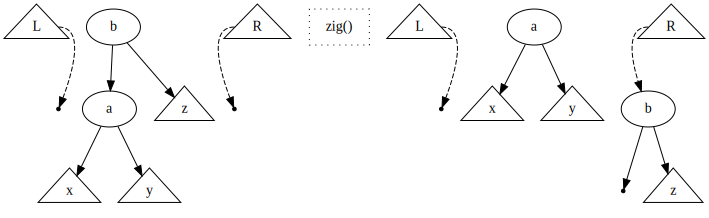

In [9]:
# flake8: noqa
# blocks solely for drawing are exempt because I consider
# semicolons and longer lines more beneficial to the reading flow there
x1 = Node("x", None, None); y1 = Node("y", None, None); z1 = Node("z", None, None)
a1 = Node("a", x1, y1); b1 = Node("b", a1, z1)
l1 = TempTree("L", None, False); r1 = TempTree("R", None, True)

x2 = Node("x", None, None); y2 = Node("y", None, None); z2 = Node("z", None, None)
a2 = Node("a", x2, y2); b2 = Node("b", None, z2)
l2 = TempTree("L", None, False); r2 = TempTree("R", b2, True)

dot = l1.graph(b1, r1, Method("zig()"), l2, a2, r2)
for subtree in x1, y1, z1, x2, y2, z2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Wurzel, wobei $b$ gemeinsam mit seinem rechten Teilbaum $z$ links unten an $R$ angefügt wird. Die Ordnung bleibt erhalten, da $b > a$ ist, und da alle Elemente, die zuvor schon in $R$ waren, auch größer als $b$ sind.

Formal definieren wir

$$\langle L, \text{Node}(b, \text{Node}(a, x, y), z), R\rangle.\text{splay_step}(a) = \langle L, \text{Node}(a, x, y), R.\text{insert_left}(\text{Node}(b, \text{Nil}, z)\rangle.\text{splay_step}(a)$$

Zu beachten ist, dass wir dabei auf das Ergebnis wieder einen Splayschritt durchführen. Wir haben zwar jetzt schon die gesuchte Nutzlast an der Wurzel, wollen aber das, was nach dem letzten regulären Schritt zu tun ist, nur einmal definieren. Hinzu kommt, dass dies für die anderen Optionen, Splay-Schritte durchzuführen, im Allgemeinen nicht der Fall ist, dann wird der Knoten noch nicht an der Wurzel sein. In der Implementierung wird später immerzu überprüft werden, ob noch ein Schritt benötigt wird, und dann der richtige Schritt ausgeführt.

Die Implementierung in Python handhaben wir ein wenig anders. Die als intern markierte Methode `_zig` bekommt Zeiger auf die momentanen Extrema in $L$ und $R$, schreibt das Objekt selbst in $R$ fest, und überschreibt die Referenz auf sich selbst dann mit dem linken Knoten unter sich. So vermeiden wir das teure Konstruieren neuer Objekte. Die neuen Extrema sowie der neue Zeiger auf den betrachteten Knoten werden zurückgegeben (erst $L$, dann der Hauptbaum, dann $R$).

In [10]:
def _zig(self, max_less, min_greater):
    # self = Node(b, Node(a, x, y), z)
    min_greater.left = self
    new_min_greater  = self
    # new_min_greater = Node(b, Node(a, x, y), z)
    new_self = self.left
    # new_self = Node(a, x, y)
    new_min_greater.left = None
    # new_min_greater = Node(b, Nil, z)
    return max_less, new_self, new_min_greater

Node._zig = _zig
del _zig

Bei *Zag* ist der zu splayende Knoten das rechte Kind der Wurzel:

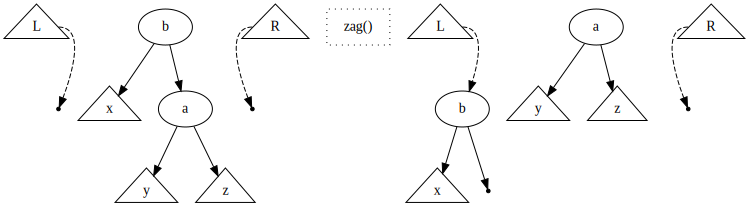

In [11]:
# flake8: noqa
x1 = Node("x", None, None); y1 = Node("y", None, None); z1 = Node("z", None, None)
a1 = Node("a", y1, z1); b1 = Node("b", x1, a1)
l1 = TempTree("L", None, False); r1 = TempTree("R", None, True)

x2 = Node("x", None, None); y2 = Node("y", None, None); z2 = Node("z", None, None)
a2 = Node("a", y2, z2); b2 = Node("b", x2, None)
l2 = TempTree("L", b2, False); r2 = TempTree("R", None, True)

dot = l1.graph(b1, r1, Method("zag()"), l2, a2, r2)
for subtree in x1, y1, z1, x2, y2, z2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Formale Definition und Implementierung sind ähnlich.

$$\langle L, \text{Node}(b, x, \text{Node}(a, y, z)), R\rangle.\text{splay_step}(a) = \langle L.\text{insert_right}(\text{Node}(b, x, \text{Nil})), \text{Node}(a, y, z),  R\rangle.\text{splay_step}(a)$$

In [12]:
def _zag(self, max_less, min_greater):
    # self = Node(b, x, Node(a, y, z))
    max_less.right = self
    new_max_less   = self
    # new_min_greater = Node(b, x, Node(a, y, z))
    new_self = self.right
    # new_self = Node(a, y, z)
    new_max_less.right = None
    # new_min_greater = Node(b, x, Nil)
    return new_max_less, new_self, min_greater

Node._zag = _zag
del _zag

### Zig-Zig und Zag-Zag

Als nächstes behandeln wir den Fall, dass der Knoten wenigstens zwei Ebenen von der Wurzel entfernt ist, und sowohl der Knoten als auch sein Elternknoten ein linkes Kind sind. Die Operation, die auf diese Ausgangssituation anzuwenden ist, bezeichnen wir als *Zig-Zig*. Diese Operation sieht so aus:

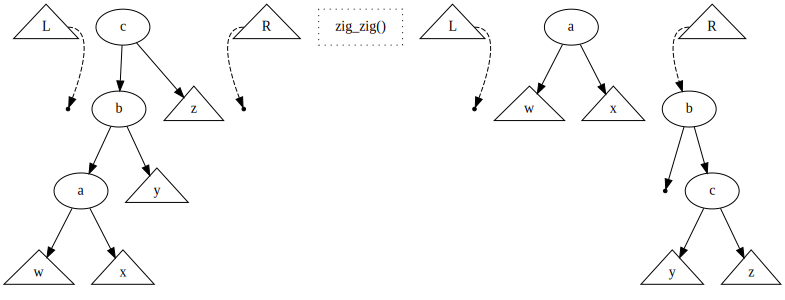

In [13]:
# flake8: noqa
w1 = Node("w", None, None); x1 = Node("x", None, None); y1 = Node("y", None, None); z1 = Node("z", None, None)
a1 = Node("a", w1, x1); b1 = Node("b", a1, y1); c1 = Node("c", b1, z1)
l1 = TempTree("L", None, False); r1 = TempTree("R", None, True)

w2 = Node("w", None, None); x2 = Node("x", None, None); y2 = Node("y", None, None); z2 = Node("z", None, None)
a2 = Node("a", w2, x2); c2 = Node("c", y2, z2); b2 = Node("b", None, c2)
l2 = TempTree("L", None, False); r2 = TempTree("R", b2, True)

dot = l1.graph(c1, r1, Method("zig_zig()"), l2, a2, r2)
for subtree in w1, x1, y1, z1, w2, x2, y2, z2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Wurzel. $b$ wird mit $c$ als rechtes Kind an $R$ angefügt, wobei $c$ als seinen linken Teilbaum $y$ hat. Die Ordnungsbedingung bleibt erhalten, da $c > b > a$ und $y > c > b$ ist.

Wir definieren

$$k < b \Rightarrow \langle L, \text{Node}(c, \text{Node}(b, \text{Node}(a, w, x), y), z), R\rangle.\text{splay_step}(k) = \langle L, \text{Node}(a, w, x), R.\text{insert_left}(\text{Node}(b, \text{Node}(c, y, z)))\rangle.\text{splay_step}(k)$$

Wir schreiben in der Implementierung wieder nur die nötigen Referenzen um. Dies sind einfach einige zusätzliche Schritte im Vergleich zu `_zig` und `_zag`.

In [14]:
def _zig_zig(self, max_less, min_greater):
    # self = Node(c, Node(b, Node(a, w, x), y), z)
    min_greater.left = self.left
    new_min_greater  = self.left
    # new min_greater = Node(b, Node(a, w, x), y)
    new_self = new_min_greater.left
    # new_self = Node(a, w, x)
    self.left = new_min_greater.right
    # self = Node(c, y, z)
    new_min_greater.left = None
    # new_min_greater = Node(b, Nil, y)
    new_min_greater.right = self
    # new_min_greater = Node(b, Nil, Node(c, y, z))
    return max_less, new_self, new_min_greater

Node._zig_zig = _zig_zig
del _zig_zig

Wir bezeichnen die gleiche Situation mit rechtem Kind und rechtem Enkel als *Zag-Zag*:

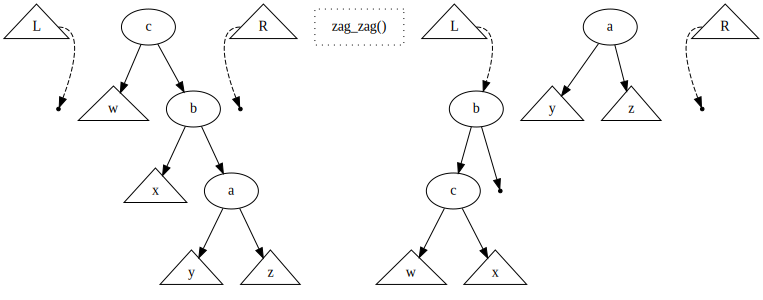

In [15]:
# flake8: noqa
w1 = Node("w", None, None); x1 = Node("x", None, None); y1 = Node("y", None, None); z1 = Node("z", None, None)
a1 = Node("a", y1, z1); b1 = Node("b", x1, a1); c1 = Node("c", w1, b1)
l1 = TempTree("L", None, False); r1 = TempTree("R", None, True)

w2 = Node("w", None, None); x2 = Node("x", None, None); y2 = Node("y", None, None); z2 = Node("z", None, None)
a2 = Node("a", y2, z2); c2 = Node("c", w2, x2); b2 = Node("b", c2, None)
l2 = TempTree("L", b2, False); r2 = TempTree("R", None, True)

dot = l1.graph(c1, r1, Method("zag_zag()"), l2, a2, r2)
for subtree in w1, x1, y1, z1, w2, x2, y2, z2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Der Splay-Schritt ist ähnlich definiert und implementiert.

$$k > b \Rightarrow \langle L, \text{Node}(c, w, \text{Node}(b, x, \text{Node}(a, y, z))), R\rangle.\text{splay_step}(k) = \langle L.\text{insert_right}(\text{Node}(b, \text{Node}(c, w, x), \text{Nil})), \text{Node}(a, y, z), R\rangle.\text{splay_step}(k)$$

In [16]:
def _zag_zag(self, max_less, min_greater):
    # self = Node(c, w, Node(b, x, Node(a, y, z)))
    max_less.right = self.right
    new_max_less  = self.right
    # new_max_less = Node(b, x, Node(a, y, z))
    new_self = new_max_less.right
    # new_self = Node(a, y, z)
    self.right = new_max_less.left
    # self = Node(c, w, x)
    new_max_less.right = None
    # new_max_less = Node(b, x, Nil)
    new_max_less.left = self
    # new_max_less = Node(b, Node(c, w, x), Nil)
    return new_max_less, new_self, min_greater

Node._zag_zag = _zag_zag
del _zag_zag

### Zig-Zag und Zag-Zig

Zuletzt behandeln wir den Fall, dass der Elternknoten ein linkes Kind, der Knoten selbst aber ein rechtes Kind ist. Die Operation auf diese Situation nennen wir *Zig-Zag*. Für diese Operation brauchen wir erstmalig sowohl $L$ als auch $R$:

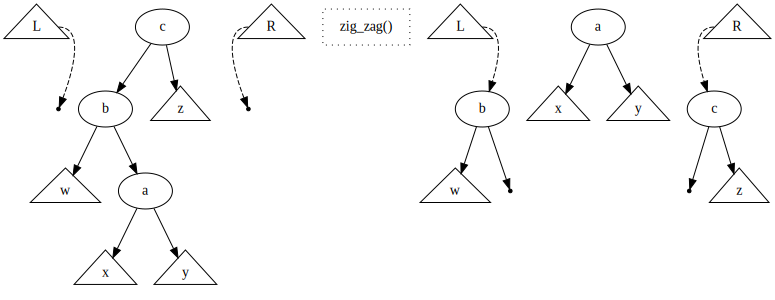

In [17]:
# flake8: noqa
w1 = Node("w", None, None); x1 = Node("x", None, None)
y1 = Node("y", None, None); z1 = Node("z", None, None)
a1 = Node("a", x1, y1); b1 = Node("b", w1, a1); c1 = Node("c", b1, z1)
l1 = TempTree("L", None, False); r1 = TempTree("R", None, True)

w2 = Node("w", None, None); x2 = Node("x", None, None)
y2 = Node("y", None, None); z2 = Node("z", None, None)
a2 = Node("a", x2, y2); b2 = Node("b", w2, None); c2 = Node("c", None, z2)
l2 = TempTree("L", b2, False); r2 = TempTree("R", c2, True)

dot = l1.graph(c1, r1, Method("zig_zag()"), l2, a2, r2)
for subtree in w1, x1, y1, z1, w2, x2, y2, z2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir bewegen den Knoten $a$ an die Stelle von $c$, dabei werden $b$ und $c$ respektive an $L$ und $R$ angefügt, die ja jeweils kleiner bzw. größer als $a$ sind.

Wir definieren

$$b < k < c \Rightarrow \langle L, \text{Node}(c, \text{Node}(b, w, \text{Node}(a, x, y)), z), R\rangle.\text{splay_step}(k) = \langle L.\text{insert_right}(\text{Node}(b, w, \text{Nil})), \text{Node}(a, x, y), R.\text{insert_left}(\text{Node}(c, \text{Nil}, z))\rangle.\text{splay_step}(k)$$

In Code haben wir

In [18]:
def _zig_zag(self, max_less, min_greater):
    # self = Node(c, Node(b, w, Node(a, x, y)), z)
    max_less.right = self.left
    new_max_less   = self.left
    # new_max_less = Node(b, w, Node(a, x, y))
    min_greater.left = self
    new_min_greater = self
    # new_min_greater = Node(c, Node(b, w, Node(a, x, y)), z)
    new_self = self.left.right
    # new_self = Node(a, x, y)
    new_max_less.right = None
    # new_max_less = Node(b, w, Nil)
    new_min_greater.left = None
    # new_min_greater = Node(c, Nil, z)
    return new_max_less, new_self, new_min_greater

Node._zig_zag = _zig_zag
del _zig_zag

In umgekehrter Reihenfolge, d.h. der Elternknoten ist das rechte Kind, der Knoten das linke Kind, haben wir die Operation *Zag-Zig* mit

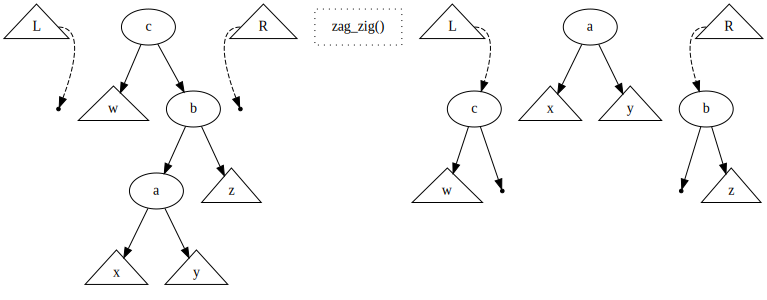

In [19]:
# flake8: noqa
w1 = Node("w", None, None); x1 = Node("x", None, None)
y1 = Node("y", None, None); z1 = Node("z", None, None)
a1 = Node("a", x1, y1); b1 = Node("b", a1, z1); c1 = Node("c", w1, b1)
l1 = TempTree("L", None, False); r1 = TempTree("R", None, True)

w2 = Node("w", None, None); x2 = Node("x", None, None)
y2 = Node("y", None, None); z2 = Node("z", None, None)
a2 = Node("a", x2, y2); b2 = Node("b", None, z2); c2 = Node("c", w2, None)
l2 = TempTree("L", c2, False); r2 = TempTree("R", b2, True)

dot = l1.graph(c1, r1, Method("zag_zig()"), l2, a2, r2)
for subtree in w1, x1, y1, z1, w2, x2, y2, z2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Formal schreiben wir

$$c < k < b \Rightarrow \langle L, \text{Node}(c, w, \text{Node}(b, \text{Node}(a, x, y), z)), R\rangle.\text{splay_step}(k) = \langle L.\text{insert_right}(\text{Node}(c, w, \text{Nil})), \text{Node}(a, x, y), R.\text{insert_left}(\text{Node}(b, \text{Nil}, z))\rangle.\text{splay_step}(k)$$

und in Code

In [20]:
def _zag_zig(self, max_less, min_greater):
    # self = Node(c, w, Node(b, Node(a, x, y), z))
    max_less.right = self
    new_max_less   = self
    # new_max_less = Node(c, w, Node(b, Node(a, x, y), z))
    min_greater.left = self.right
    new_min_greater = self.right
    # new_min_greater = Node(b, Node(a, x, y), z)
    new_self = self.right.left
    # new_self = Node(a, x, y)
    new_max_less.right = None
    # new_max_less = Node(c, w, Nil)
    new_min_greater.left = None
    # new_min_greater = Node(b, Nil, z)
    return new_max_less, new_self, new_min_greater

Node._zag_zig = _zag_zig
del _zag_zig

### Vergleich beliebiger Nutzlasten

Wir müssen, um später Mengen, die Elemente unterschiedlicher Typen enthalten, zu unterstützen, dazu in der Lage sein, beliebige Nutzlasten zu vergleichen. Dazu versuchen wir den direkten Vergleich, und vergleichen, wenn das nicht funktioniert, am Klassennamen. So kommen wertgleiche Fließkomma- und Ganzzahlen nur einmal in die Menge (dies ist auch bei Python-Mengen so). Die Methoden, die wir dazu schreiben, geben wir der Klasse `Node` mit, um so wenig wie möglich in den Namespace zu laden, und somit die Einsetzbarkeit zu erhöhen. `_arb_gt(x, y)` überprüft, ob im Sinne dieses Vergleichs `x` $>$ `y` ist.

In [21]:
def _arb_gt(self, x, y):
    try:
        return y < x
    except TypeError:
        return type(x).__name__ > type(y).__name__

Node._arb_gt = _arb_gt
del _arb_gt

`_arb_lt(x, y)` überprüft `x` $<$ `y`…

In [22]:
def _arb_lt(self, x, y):
    try:
        return x < y
    except TypeError:
        return type(x).__name__ < type(y).__name__

Node._arb_lt = _arb_lt
del _arb_lt

…und `_arb_eq(x, y)` überprüft `x == y`.

In [23]:
def _arb_eq(self, x, y):
    try:
        return x == y
    except TypeError:
        return False

Node._arb_eq = _arb_eq
del _arb_eq

### Verkettung der Schritte

Der formalen Definition fehlt noch der Basisfall, wenn die Wurzel die zu splayende Nutzlast enthält. Wir fügen dann $L$ und $R$ an die neue Wurzel an – die Knoten in $L$ und $R$ waren ja gerade eben kleiner bzw. größer als die Wurzel. Wir fügen dabei die Teilbäume, die die Wurzel jetzt noch hat, in $L$ und $R$ ein; links von der Wurzel sind alle Nutzlasten, die größer als $L$ sind, und rechts sind alle, die kleiner als $R$ sind.

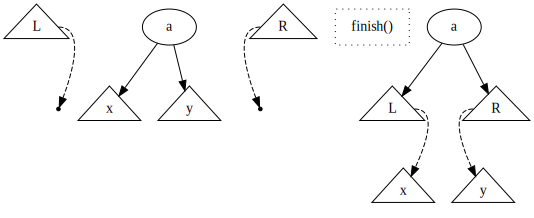

In [24]:
# flake8: noqa
x1 = Node("x", None, None); y1 = Node("y", None, None); a1 = Node("a", x1, y1)
l1 = TempTree("L", None, False); r1 = TempTree("R", None, True)

x2 = Node("x", None, None); y2 = Node("y", None, None)
l2 = TempTree("L", x2, False); r2 = TempTree("R", y2, True)
a2 = Node("a", l2, r2)

dot = l1.graph(a1, r1, Method("finish()"), a2)
for subtree in x1, y1, x2, y2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir definieren:

$$\langle L, \text{Node}(a, x, y), R\rangle.\text{splay_step}(a) = \langle\text{Nil}, \text{Node}(a, L.\text{insert_right}(x), R.\text{insert_left}(y)), \text{Nil}\rangle$$

Wir müssen allerdings auch den Basisfall betrachten, dass wir feststellen, dass der Knoten nicht vorhanden ist, weil da, wo der Knoten stünde, keine Knoten mehr sind. In diesem Fall müssen wir nur noch den anderen Teilbaum anfügen.

$$\begin{align}
k < a &\Rightarrow \langle L, \text{Node}(a, \text{Nil}, y), R\rangle.\text{splay_step}(k) = \langle\text{Nil}, \text{Node}(a, L, R.\text{insert_left}(y)), \text{Nil}\rangle \\
k > a &\Rightarrow \langle L, \text{Node}(a, x, \text{Nil}), R\rangle.\text{splay_step}(k) = \langle\text{Nil}, \text{Node}(a, L.\text{insert_right}(x), R), \text{Nil}\rangle
\end{align}$$

In der Implementierung wählen wir so lange den angemessenen Schritt aus und führen ihn durch, bis wir an den gesuchten Knoten kommen oder erfolglos an ein Blatt stoßen. So vermeiden wir Funktionsaufrufe und die Grenzen von Rekursionstiefe. Falls der gesuchte Knoten noch genau eine Ebene entfernt ist, so führen wir Zig bzw. Zag durch. In diesem Fall unterscheiden wir:

|Linkes Kind|Rechtes Kind|
|:----------|:-----------|
|Zig        |Zag         |

Falls er noch mindestens zwei Ebenen entfernt ist, so unterscheiden wir:

|Kind vs. Enkel   |Linkes Kind|Rechtes Kind|
|----------------:|:----------|:-----------|
|**Linker Enkel** |Zig-Zig    |Zag-Zig     |
|**Rechter Enkel**|Zig-Zag    |Zag-Zag     |

Um diese Implementierung später besser mit anderen rekursiv implementierten Datenstrukturen vergleichen zu können, implementieren wir den `_splay_step` jetzt auch rekursiv:

In [25]:
def _splay_step(self, max_less, min_greater, payload):
    if self._arb_lt(payload, self.payload):
        if self.left is None:
            return max_less, self, min_greater
        if self._arb_lt(payload, self.left.payload) \
                and self.left.left is not None:
            new_max_less, new_self, new_min_greater = \
                self._zig_zig(max_less, min_greater)
            return new_self._splay_step(new_max_less, new_min_greater, payload)
        if self._arb_gt(payload, self.left.payload) \
                and self.left.right is not None:
            new_max_less, new_self, new_min_greater = \
                self._zig_zag(max_less, min_greater)
            return new_self._splay_step(new_max_less, new_min_greater, payload)
        return self._zig(max_less, min_greater)
    if self._arb_gt(payload, self.payload):
        if self.right is None:
            return max_less, self, min_greater
        if self._arb_gt(payload, self.right.payload) \
                and self.right.right is not None:
            new_max_less, new_self, new_min_greater = \
                self._zag_zag(max_less, min_greater)
            return new_self._splay_step(new_max_less, new_min_greater, payload)
        if self._arb_lt(payload, self.right.payload) \
                and self.right.left is not None:
            new_max_less, new_self, new_min_greater = \
                self._zag_zig(max_less, min_greater)
            return new_self._splay_step(new_max_less, new_min_greater, payload)
        return self._zag(max_less, min_greater)
    return max_less, self, min_greater

Node._splay_step = _splay_step
del _splay_step

In der Zusammensetzung `_splay` fügen wir noch die Teilbäume von der neuen Wurzel an $L, R$ an und setzen $L, R$ als Teilbäume dieser neuen Wurzel. Wir benutzen statt $L, R$ nur einen Baum `set_aside`, bei dem wir auf der entsprechenden Seite anfügen.

In [26]:
def _splay(self, payload):
    set_aside = Node(None, None, None)
    max_less, new_self, min_greater = \
        self._splay_step(set_aside, set_aside, payload)
    max_less.right   = new_self.left
    min_greater.left = new_self.right
    new_self.left    = set_aside.right
    new_self.right   = set_aside.left
    return new_self

Node._splay = _splay
del _splay

Das nächste Beispiel zeigt, wie ein Splay aus einem schlechtestmöglich balancierten Baum einen deutlich besser balancierten Baum machen kann:

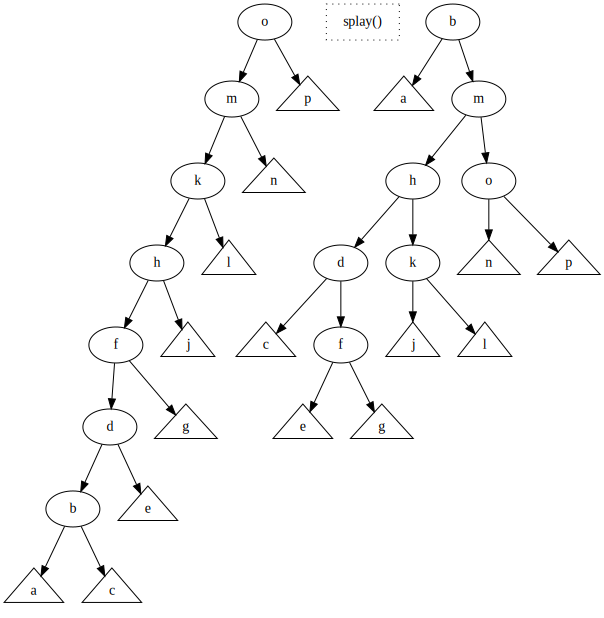

In [27]:
# flake8: noqa
a1 = Node("a", None, None); c1 = Node("c", None, None); e1 = Node("e", None, None); g1 = Node("g", None, None)
j1 = Node("j", None, None); l1 = Node("l", None, None); n1 = Node("n", None, None); p1 = Node("p", None, None)
b1 = Node("b", a1, c1); d1 = Node("d", b1, e1); f1 = Node("f", d1, g1); h1 = Node("h", f1, j1)
k1 = Node("k", h1, l1); m1 = Node("m", k1, n1); o1 = Node("o", m1, p1)

a2 = Node("a", None, None); c2 = Node("c", None, None); e2 = Node("e", None, None); g2 = Node("g", None, None)
j2 = Node("j", None, None); l2 = Node("l", None, None); n2 = Node("n", None, None); p2 = Node("p", None, None)
b2 = Node("b", a2, c2); d2 = Node("d", b2, e2); f2 = Node("f", d2, g2); h2 = Node("h", f2, j2)
k2 = Node("k", h2, l2); m2 = Node("m", k2, n2); o2 = Node("o", m2, p2)

dot = o1.graph(Method("splay()"), o2._splay("b"))
for subtree in a1, c1, e1, g1, j1, l1, n1, p1, a2, c2, e2, g2, j2, l2, n2, p2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Ein anderes Beispiel enthält alle Schritte außer Zag:

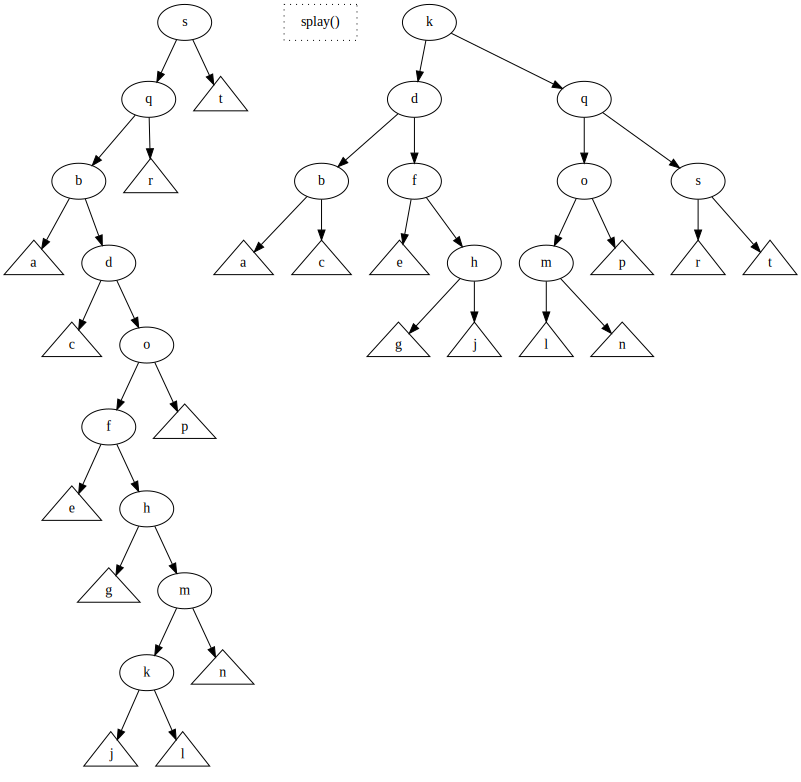

In [28]:
# flake8: noqa
j1 = Node("j", None, None); l1 = Node("l", None, None); n1 = Node("n", None, None); g1 = Node("g", None, None)
e1 = Node("e", None, None); p1 = Node("p", None, None); c1 = Node("c", None, None); a1 = Node("a", None, None)
r1 = Node("r", None, None); t1 = Node("t", None, None)
k1 = Node("k", j1, l1); m1 = Node("m", k1, n1); h1 = Node("h", g1, m1); f1 = Node("f", e1, h1)
o1 = Node("o", f1, p1); d1 = Node("d", c1, o1); b1 = Node("b", a1, d1); q1 = Node("q", b1, r1)
s1 = Node("s", q1, t1)

j2 = Node("j", None, None); l2 = Node("l", None, None); n2 = Node("n", None, None); g2 = Node("g", None, None)
e2 = Node("e", None, None); p2 = Node("p", None, None); c2 = Node("c", None, None); a2 = Node("a", None, None)
r2 = Node("r", None, None); t2 = Node("t", None, None)
k2 = Node("k", j2, l2); m2 = Node("m", k2, n2); h2 = Node("h", g2, m2); f2 = Node("f", e2, h2)
o2 = Node("o", f2, p2); d2 = Node("d", c2, o2); b2 = Node("b", a2, d2); q2 = Node("q", b2, r2)
s2 = Node("s", q2, t2)

dot = s1.graph(Method("splay()"), s2._splay("k"))
for subtree in a1, c1, e1, g1, j1, l1, n1, p1, r1, t1, a2, c2, e2, g2, j2, l2, n2, p2, r2, t2:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir betrachten zuletzt das folgende Beispiel, um Zag abgedeckt zu haben:

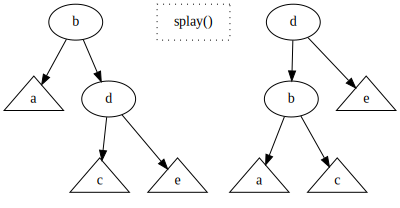

In [29]:
# flake8: noqa
a1 = Node("a", None, None); c1 = Node("c", None, None); e1 = Node("e", None, None)
d1 = Node("d", c1, e1); b1 = Node("b", a1, d1)

a2 = Node("a", None, None); c2 = Node("c", None, None); e2 = Node("e", None, None)
d2 = Node("d", c2, e2); b2 = Node("b", a2, d2)

dot = b1.graph(Method("splay()"), b2._splay("d"))
for subtree in a1, c1, e1, a2, c2, e2:
    dot.node(str(id(subtree)), shape="triangle")
dot

## Standardoperationen

Wir definieren für den Splay Tree als nächstes die grundlegenden Operationen auf Bäume: Einfügen, Löschen, auf das Vorhandensein eines Elements überprüfen, und auf das Leersein überprüfen.

### Einfügen

Wir definieren das Einfügen eines Elementes, bei dem in einen bestehenden Baum eine neue Nutzlast eingefügt wird, wodurch sich der Baum i.A. verändert.

$$\text{Node}.\text{insert}: \text{Payload} \to \text{Node}$$

Beim Einfügen traversieren wir nicht, wie bei den meisten Bäumen und auch bei der Verwendung des Bottom-Up-Splaying-Ansatzes, den Baum hinunter, sondern splayen an dem Element, das wir einfügen wollen. Offenbar ist die Wurzel des gesplayten Baums dann entweder schon das einzufügende Element; in diesem Fall sind wir fertig. Wir bezeichnen den Baum mit $B$ und das neue Element mit $k$. Ist der Baum noch leer, so brauchen wir nur die Wurzel setzen:

$$\begin{align}
B = \text{Nil} &\Rightarrow B.\text{insert}(k) = \text{Node}(k, \text{Nil}, \text{Nil}) \\
B.\text{splay}(k) = \text{Node}(k, x, y) &\Rightarrow B.\text{insert}(k) = B.\text{splay}(k)
\end{align}$$

Andernfalls ist die neue Wurzel genau das Element, das im ganzen Baum das nächstgrößere oder nächstkleinere als das einzufügende Element ist, oder formaler:

$$B.\text{splay}(k) = \text{Node}(x, y, z) \Rightarrow x = k \lor x = \max(\{\kappa \in B: \kappa < k\}) \lor x = \min(\{\kappa \in B: \kappa > k\})$$

In diesen beiden Fällen setzen wir das einzufügende Element $k$ als Wurzel. Im Fall, dass $k$ kleiner als die Wurzel des gesplayten existierenden Baums $B' = \text{Node}(x, y, z)$ ist, sind trotzdem alle Elemente im linken Teilbaum $y$ von $B'$ kleiner als $k$ und wir setzen diesen als linken Teilbaum von $k$. Wir setzen die Wurzel $x$ von $B'$ als rechten Teilbaum, da sie, wie auch alle Elemente des rechten Teilbaums $z$ von $B'$ größer als $k$ sind. Dabei setzen wir den linken Teilbaum von $x$ auf $\text{Nil}$.

$$B.\text{splay}(k) = \text{Node}(x, y, z) \land k < x \Rightarrow B.\text{insert}(k) = \text{Node}(k, y, \text{Node}(x, \text{Nil}, z))$$

oder graphisch:

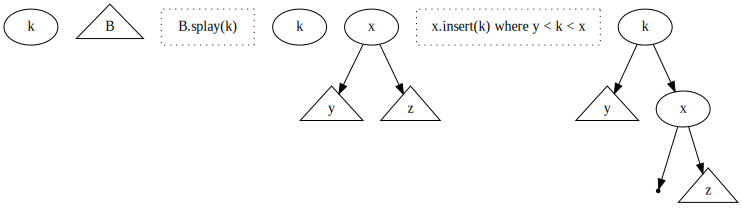

In [30]:
# flake8: noqa
B = Node("B", None, None); k1 = Node("k", None, None)
y2 = Node("y", None, None); z2 = Node("z", None, None); x2 = Node("x", y2, z2); k2 = Node("k", None, None)
y3 = Node("y", None, None); z3 = Node("z", None, None); x3 = Node("x", None, z3); k3 = Node("k", y3, x3)

dot = k1.graph(B, Method("B.splay(k)"), k2, x2, Method("x.insert(k) where y < k < x"), k3)
for subtree in B, y2, z2, y3, z3:
    dot.node(str(id(subtree)), shape="triangle")
dot

Im Fall, dass $k$ größer als die Wurzel $x$ des gesplayten Baums $B' = \text{Node}(x, y, z)$ ist, sind umgekehrt alle Elemente in dessen rechten Teilbaum $z$ größer als $k$, und wir setzen die Wurzel dieses Baumes $x$ als linken Teilbaum des neuen Elements $k$, wobei dieser Knoten dann als linken Teilbaum $y$ hat, als rechten Teilbaum $\text{Nil}$.

$$B.\text{splay}(k) = \text{Node}(x, y, z) \land k > x \Rightarrow B.\text{insert}(k) = \text{Node}(k, \text{Node}(x, y, \text{Nil}), z)$$

und graphisch:

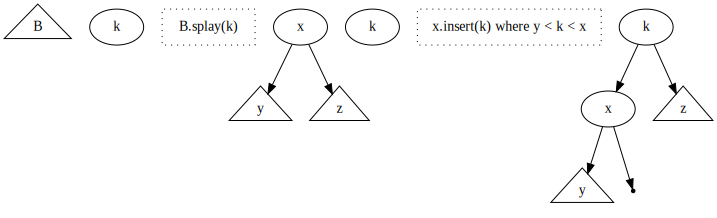

In [31]:
# flake8: noqa
B = Node("B", None, None); k1 = Node("k", None, None)
y2 = Node("y", None, None); z2 = Node("z", None, None); x2 = Node("x", y2, z2); k2 = Node("k", None, None)
y3 = Node("y", None, None); z3 = Node("z", None, None); x3 = Node("x", y3, None); k3 = Node("k", x3, z3)

dot = B.graph(k1, Method("B.splay(k)"), x2, k2, Method("x.insert(k) where y < k < x"), k3)
for subtree in B, y2, z2, y3, z3:
    dot.node(str(id(subtree)), shape="triangle")
dot

In [32]:
def insert(self, payload):
    self = self._splay(payload)
    if self._arb_eq(payload, self.payload):
        return self
    if self._arb_lt(payload, self.payload):
        tmp = self.left
        self.left = None
        return Node(payload, tmp, self)
    tmp = self.right
    self.right = None
    return Node(payload, self, tmp)

Node.insert = insert
del insert

Für den leeren Baum brauchen wir nur das Element in einen neuen Knoten setzen. Wir definieren – unter anderem zur Betrachtung des Falls des leeren Baumes – die Klasse `SplayTree`, die das Management des leeren Baums wie auch der Tatsache, dass sich bei einem Splay die Wurzel ändert, nach außen vereinfacht.

In [33]:
class SplayTree:
    def __init__(self):
        self.tree = None

    def insert(self, payload):
        if self.tree is None:
            self.tree = Node(payload, None, None)
        else:
            self.tree = self.tree.insert(payload)

Für den `SplayTree` definieren wir außerdem `graph`, um `Node.graph` zu exponieren.

In [34]:
def graph(self):
    if self.tree is None:
        return graphviz.Digraph()
    return self.tree.graph()

SplayTree.graph = graph
del graph

Einige Beispiele zeigen das Einsetzen von Knoten in Splay Trees:

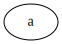

In [35]:
my_splay = SplayTree()
my_splay.insert("a")
my_splay.graph()

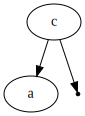

In [36]:
my_splay.insert("c")
my_splay.graph()

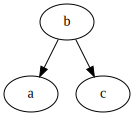

In [37]:
my_splay.insert("b")
my_splay.graph()

### Entfernen

Wir definieren als nächstes das Entfernen eines Elementes, bei dem ebenfalls eine Nutzlast aus einem bestehenden Baum entfernt wird, wobei sich der Baum i.A. verändert.

$$\text{Node}.\text{remove}: \text{Payload} \to \text{Node}$$

Wir splayen wieder am zu entfernenden Element und haben dann einen Baum, der das zu entfernende Element als Wurzel hat. Sollte sich nach dem Splayen herausstellen, dass das Element nicht vorhanden ist, werfen wir einen `KeyError`, [da sich so auch die Mengen in Python verhalten](https://docs.python.org/3.7/library/stdtypes.html#set "Python Software Foundation (2019): The Python Standard Library/Built-in Types/set, Python Documentation"). In der Definition schreiben wir $\downarrow$ für das Undefinierte. Dies tritt auch ein, wenn der Baum leer ist:

$$\begin{align}
B = \text{Nil} &\Rightarrow B.\text{remove}(k)\downarrow \\
B.\text{splay}(k) \neq \text{Node}(k, x, y) &\Rightarrow B.\text{remove}(k)\downarrow
\end{align}$$

Andernfalls überprüfen wir, ob ein Teilbaum des gesplayten Baums leer ist. In diesem Fall ist der neue Baum einfach der andere Teilbaum.

$$\begin{align}
B.\text{splay}(k) = \text{Node}(k, \text{Nil}, x) &\Rightarrow B.\text{remove}(k) = x \\
B.\text{splay}(k) = \text{Node}(k, x, \text{Nil}) &\Rightarrow B.\text{remove}(k) = x
\end{align}$$

Ist das nicht der Fall, so sorgen wir dafür, dass der rechte Teilbaum des gesplayten Baums keinen linken Teilbaum mehr hat, sodass wir den linken Teilbaum des gesplayten Baums anfügen können. Eine Grafik illustriert, was gemeint ist:

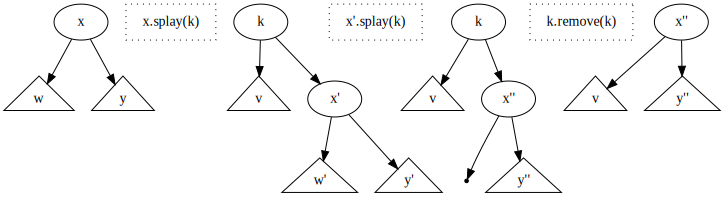

In [38]:
# flake8: noqa
w1 = Node("w", None, None); y1 = Node("y", None, None); x1 = Node("x", w1, y1)
v2 = Node("v", None, None); w2 = Node("w'", None, None); y2 = Node("y'", None, None); x2 = Node("x'", w2, y2); k2 = Node("k", v2, x2)
v3 = Node("v", None, None); y3 = Node("y''", None, None); x3 = Node("x''", None, y3); k3 = Node("k", v3, x3)
v4 = Node("v", None, None); y4 = Node("y''", None, None); x4 = Node("x''", v4, y4)

dot = x1.graph(Method("x.splay(k)"), k2, Method("x'.splay(k)"), k3, Method("k.remove(k)"), x4)
for subtree in w1, y1, v2, w2, y2, v3, y3, v4, y4:
    dot.node(str(id(subtree)), shape="triangle")
dot

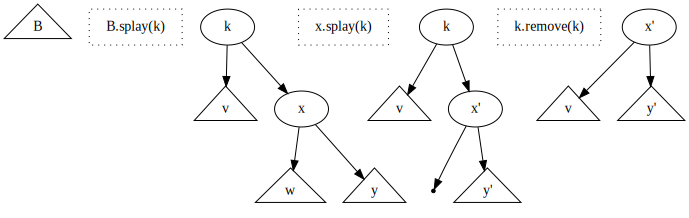

In [39]:
# flake8: noqa
B = Node("B", None, None)
v1 = Node("v", None, None); w1 = Node("w", None, None); y1 = Node("y", None, None); x1 = Node("x", w1, y1); k1 = Node("k", v1, x1)
v2 = Node("v", None, None); y2 = Node("y'", None, None); x2 = Node("x'", None, y2); k2 = Node("k", v2, x2)
v3 = Node("v", None, None); y3 = Node("y'", None, None); x3 = Node("x'", v3, y3)

dot = B.graph(Method("B.splay(k)"), k1, Method("x.splay(k)"), k2, Method("k.remove(k)"), x3)
for subtree in B, v1, w1, y1, v2, y2, v3, y3:
    dot.node(str(id(subtree)), shape="triangle")
dot

Wir machen aus dem Baum $\text{Node}(x, w, y)$ den Baum $\text{Node}(x', \text{Nil}, y')$, indem wir an $k$ splayen. Da das Minimum aus $\text{Node}(x, w, y)$ größer $k$ ist, muss dann gerade dieses Minimum die Wurzel ($x'$) werden und kann keinen linken Teilbaum mehr haben.

$$B.\text{splay}(k) = \text{Node}(k, v, \text{Node}(x, w, y)) \land \text{Node}(x, w, y).\text{splay}(k) = \text{Node}(x', \text{Nil}, y') \Rightarrow B.\text{remove}(k) = \text{Node}(x', v, y')$$

Für `Node` implementieren wir:

In [40]:
def remove(self, payload):
    self = self._splay(payload)
    if not self._arb_eq(payload, self.payload):
        return False, self
    if self.left is None:
        return True, self.right
    if self.right is None:
        return True, self.left
    tmp       = self.left
    self      = self.right._splay(payload)
    self.left = tmp
    return True, self

Node.remove = remove
del remove

Wir werfen in der Implementierung erst auf Ebene von `SplayTree` den `KeyError`, um im Baum noch aufräumen zu können. Der Nutzer könnte ja im Falle eines `KeyError`s diesen auffangen wollen und die Menge trotzdem noch benutzen wollen.

In [41]:
def remove(self, payload):
    if self.tree is None:
        raise KeyError(payload)
    rc, self.tree = self.tree.remove(payload)
    if not rc:
        raise KeyError(payload)

SplayTree.remove = remove
del remove

Einige Beispiele zeigen das Entfernen von Elementen.

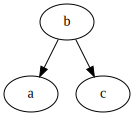

In [42]:
my_splay = SplayTree()
for letter in ["a", "c", "b"]:
    my_splay.insert(letter)
my_splay.graph()

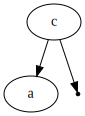

In [43]:
my_splay.remove("b")
my_splay.graph()

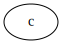

In [44]:
my_splay.remove("a")
my_splay.graph()

### Finden

Wir definieren als nächstes das Überprüfen eines Baumes auf ein Element. In unserer Definition wird ein Tupel aus dem Vorhandensein und der neuen Wurzel zurückgegeben.

$$\text{Node}.\text{contains}: \text{Payload} \to \langle\mathbb{B}, \text{Node}\rangle$$

Wir splayen am gesuchten Element und können schon an der Wurzel erkennen, ob das Element vorhanden ist. Noch einfacher haben wir es, wenn keine Elemente im Baum sind:

$$\begin{align}
B = \text{Nil} &\Rightarrow B.\text{contains}(k) = (\text{false}, \text{Nil}) \\
B.\text{splay}(k) = \text{Node}(k, y, z) &\Rightarrow B.\text{contains}(k) = (\text{true}, \text{Node}(k, y, z)) \\
B.\text{splay}(k) = \text{Node}(x, y, z) \land k \neq x &\Rightarrow B.\text{contains}(k) = (\text{false}, \text{Node}(x, y, z))
\end{align}$$

Wir haben für `Node`

In [45]:
def contains(self, payload):
    self = self._splay(payload)
    return self._arb_eq(payload, self.payload), self

Node.contains = contains
del contains

und für den `SplayTree`

In [46]:
def contains(self, payload):
    if self.tree is None:
        return False
    contains, self.tree = self.tree.contains(payload)
    return contains

SplayTree.contains = contains
del contains

Beispiele zeigen uns:

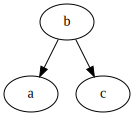

In [47]:
my_splay = SplayTree()
for letter in ["a", "c", "b"]:
    my_splay.insert(letter)
my_splay.graph()

In [48]:
my_splay.contains("a")

True

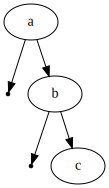

In [49]:
my_splay.graph()

In [50]:
my_splay.contains("d")

False

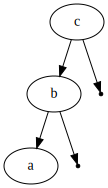

In [51]:
my_splay.graph()

### Leerüberprüfung

Wir definieren zuletzt, wie wir überprüfen, ob der Baum leer ist.

$$\text{Node}.\text{is_empty}: \langle\rangle \to \mathbb{B}$$
$$\text{Node}.\text{is_empty}() = (\text{Node} = \text{Nil})$$

Die Implementierung findet von `SplayTree` aus statt.

In [52]:
def is_empty(self):
    return self.tree is None

SplayTree.is_empty = is_empty
del is_empty

In [53]:
my_splay = SplayTree()
my_splay.is_empty()

True

In [54]:
my_splay.insert("a")
my_splay.is_empty()

False

## Demonstration

Als kleine Demonstration von `SplayTree` implementieren wir damit die Ermittlung aller Primzahlen bis zu einer Zahl `n` mit dem *Sieb des Eratosthenes*:

In [55]:
def primes(n):
    primes = SplayTree()
    for i in range(2, n + 1):
        primes.insert(i)
    for i in range(2, n + 1):
        for j in range(2 * i, n + 1, i):
            try:
                primes.remove(j)
            except KeyError:
                pass
    return primes

Da die Zahlen sequenziell betrachtet wurden, ist der Baum zunächst maximal unbalanciert:

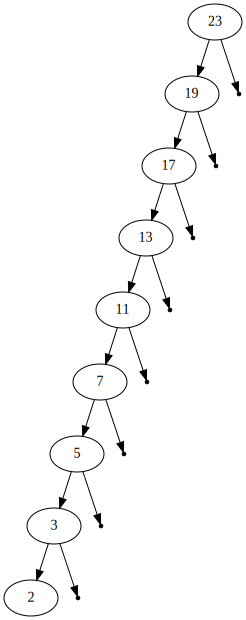

In [56]:
tree = primes(25)
tree.graph()

Wir sehen aber zum Beispiel, dass schon durch einen Splay ein deutlich besser balancierter Baum entsteht:

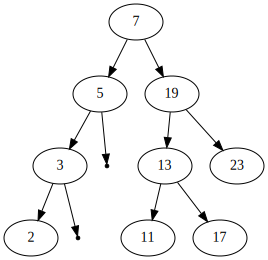

In [57]:
tree.tree = tree.tree._splay(7)
tree.graph()

Da wir dieses Notebook noch wiederverwenden, entfernen wir irrelevante Namen aus dem Namespace.

In [58]:
del B, a1, a2, b1, b2, c1, c2, d1, d2, dot, e1, e2, f1, f2, g1, g2, h1, h2,   \
    j1, j2, k1, k2, k3, l1, l2, letter, m1, m2, my_splay, n1, n2, o1, o2, p1, \
    p2, q1, q2, r1, r2, s1, s2, subtree, t1, t2, v1, v2, v3, v4, w1, w2, x1,  \
    x2, x3, x4, y1, y2, y3, y4, z1, z2, z3